In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch
import dgl
import torch_geometric.utils.convert
import torch_geometric.transforms as T
from torch_geometric.datasets.dblp import DBLP
import community as community_louvain
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

### DBLP

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_graph= g.metagraph()

In [3]:
def get_node_type(node_type):
    if node_type == 1:
        return 'author'
    elif node_type == 0:
        return 'paper'
    elif node_type == 2:
        return 'term'
    elif node_type == 3:
        return 'conference'

In [4]:
list(meta_graph.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [5]:
def graph_gen(nodeid, G):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
    #Get small graph edges
    edges = [e for e in graph.edges]
    
    node_types=nx.get_node_attributes(graph, "class")
   
    source,dest =list(map(list, zip(*edges)))
    remaining_edges = []
    
    for i in range(len(edges)):
        source_node_type = get_node_type(node_types[source[i]])
        dest_node_type = get_node_type(node_types[dest[i]])
        
        if not (source_node_type,dest_node_type) in list(meta_graph.edges()):
            remaining_edges.append((source[i],dest[i]))
    
    graph.remove_edges_from(remaining_edges)        
    graph.remove_nodes_from(list(nx.isolates(graph)))
    print('nodeid',nodeid)
    print('node count',graph.number_of_nodes())
    print('edge count',graph.number_of_edges())
    #print(remaining_edges)
    return graph

In [6]:
def plot_graph(G):

    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}

    nx.draw(G, 
        with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=200,
        font_color='white')
    plt.show() 

In [7]:
def plot_partition(G,partition):
    # draw the graph
    pos = nx.spring_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=100,label=True,
                            cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

In [8]:
def detect_community(G):
    partition = community_louvain.best_partition(G)
    plot_partition(G,partition)

In [9]:
G_syn_dblp = nx.read_gexf('DBLP_four_area_hgen.gexf')

Explanation graph of class 0

nodeid 477
node count 18
edge count 17


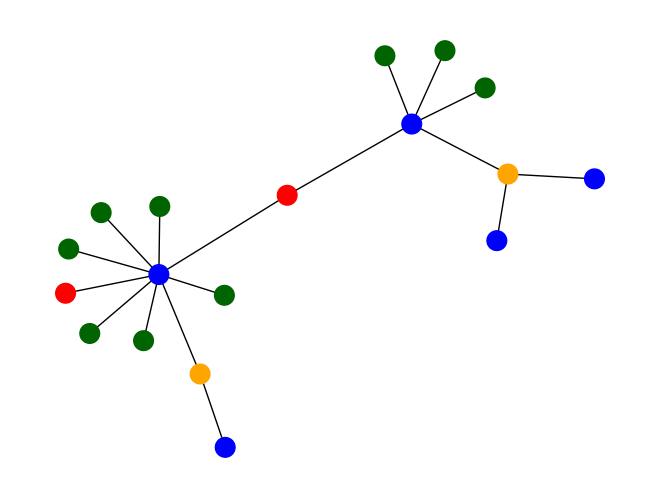

In [10]:
class0 = graph_gen('477', G_syn_dblp)
plot_graph(class0)

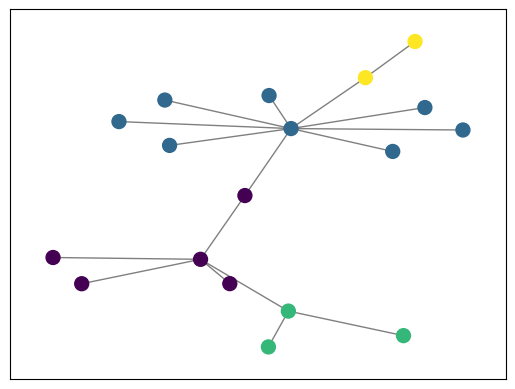

[{'11236', '5662', '6450'},
 {'477', '6513', '7591', '7611', '9759'},
 {'11239', '6166'},
 {'10209', '10939', '1821', '5334', '8198', '9022', '9117', '9548'}]

In [11]:
detect_community(class0)
list_com= nx.community.louvain_communities(class0, seed=123)
list_com

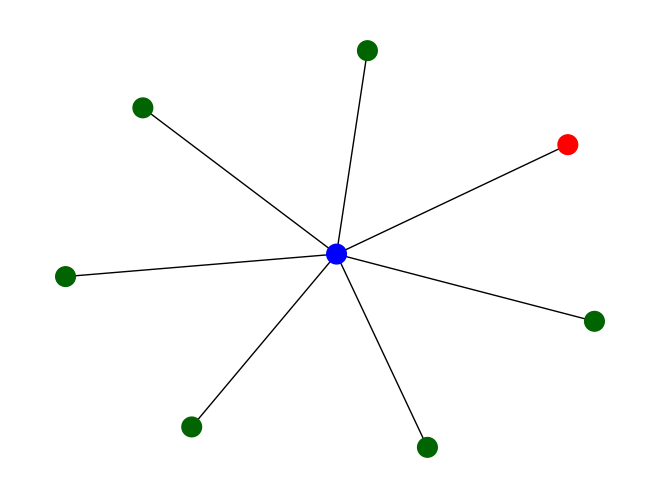

In [12]:
#Largest substructure
H = class0.subgraph(max(list_com, key=len))
plot_graph(H)

Explanation graph of class 1

nodeid 1416
node count 29
edge count 35


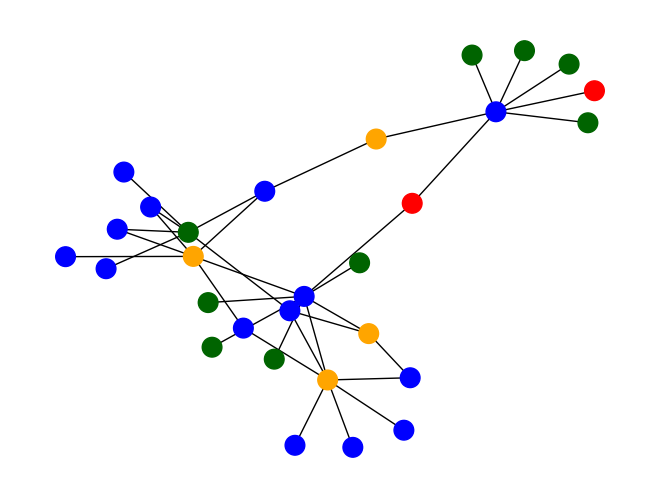

In [13]:
class1 = graph_gen('1416', G_syn_dblp)
plot_graph(class1)

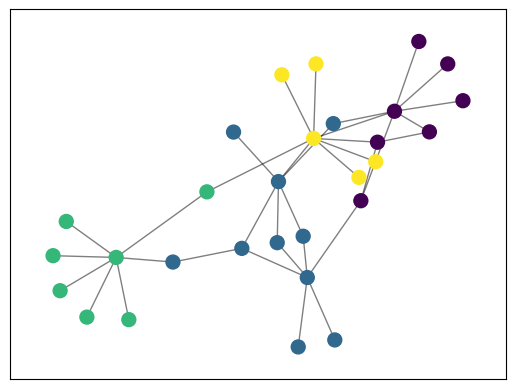

[{'1416', '1598', '5934', '8166', '8331', '8358', '9313'},
 {'11235', '11236', '4693', '4892', '4982', '5635', '6539'},
 {'5495', '7762', '8060', '8621', '9084'},
 {'11238',
  '11239',
  '5128',
  '5134',
  '5454',
  '5480',
  '5651',
  '5995',
  '6561',
  '7695'}]

In [14]:
detect_community(class1)
list_com= nx.community.louvain_communities(class1, seed=123)
list_com

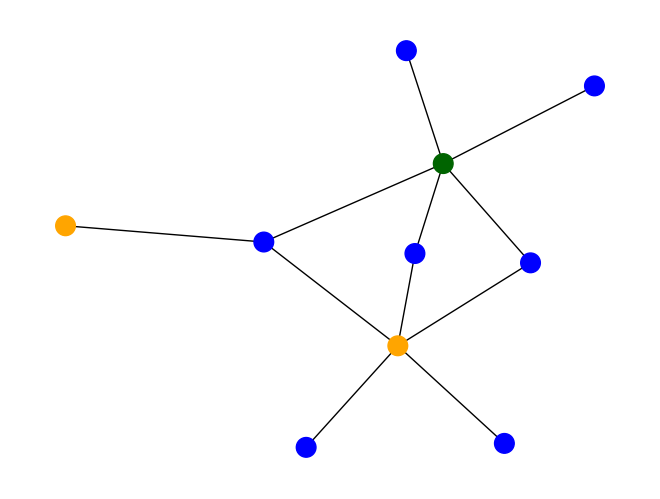

In [15]:
#Largest substructure
H = class1.subgraph(max(list_com, key=len))
plot_graph(H)

Explanation graph of class 2

nodeid 3288
node count 13
edge count 16


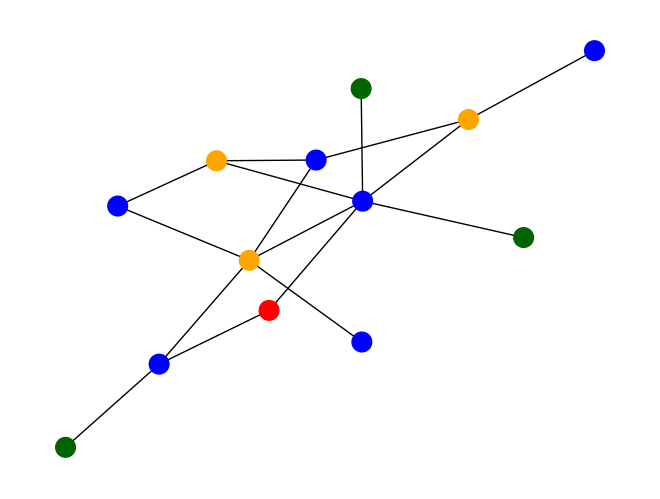

In [16]:
class2 = graph_gen('3288', G_syn_dblp)
plot_graph(class2)

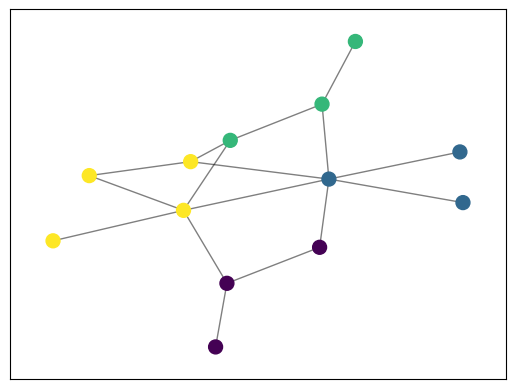

[{'11223', '6695', '7662'},
 {'11237', '11239', '5615', '6157'},
 {'3288', '4927', '7741'},
 {'11236', '6481', '7059'}]

In [17]:
detect_community(class2)
list_com= nx.community.louvain_communities(class2, seed=123)
list_com

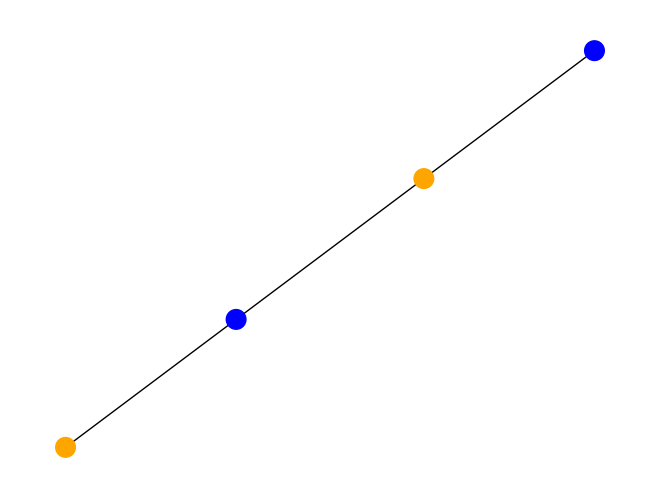

In [18]:
#Largest substructure
H = class2.subgraph(max(list_com, key=len))
plot_graph(H)

Explanation graph of class 3

nodeid 155
node count 16
edge count 17


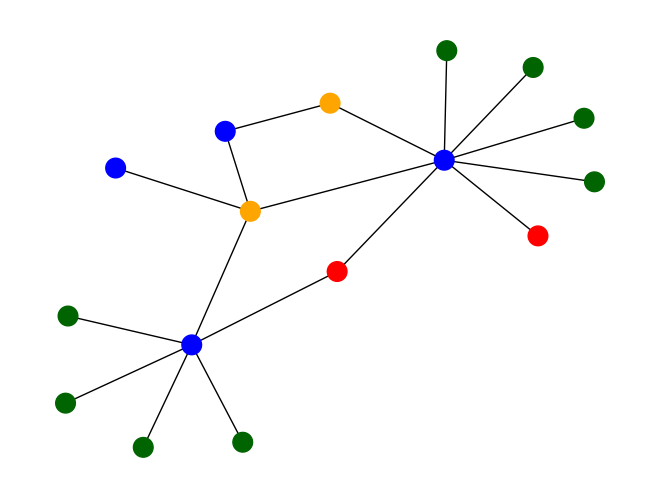

In [19]:
class3 = graph_gen('155', G_syn_dblp)
plot_graph(class3)

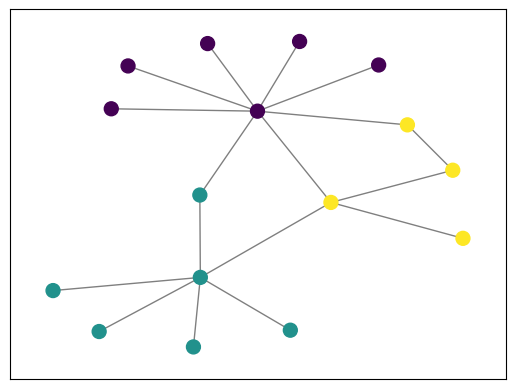

[{'10332', '10873', '3489', '6281', '8375', '9564'},
 {'155', '6293', '7775', '8012', '8528', '8870'},
 {'11236', '11239', '6144', '6758'}]

In [20]:
detect_community(class3)
list_com= nx.community.louvain_communities(class3, seed=123)
list_com

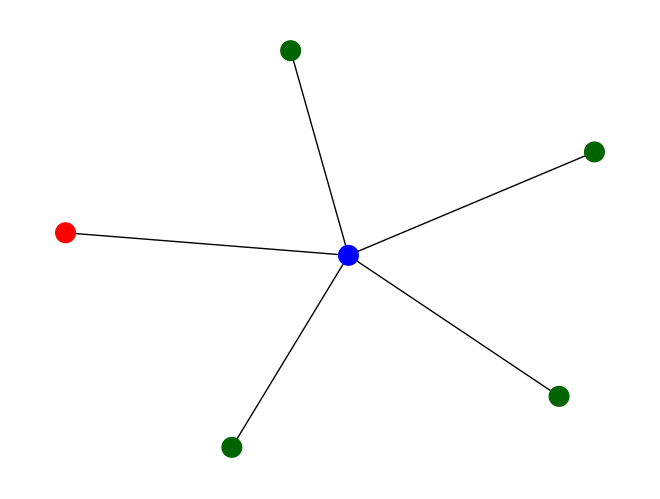

In [21]:
H = class3.subgraph(max(list_com, key=len))
plot_graph(H)